<a href="https://colab.research.google.com/github/Roger8886/Taiwan-stock-prediction/blob/main/Taiwan_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 台灣股市資料收集

In [ ]:
# 安裝twstock模組
!pip install twstock

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.8 MB/s 


In [ ]:
# 載入twstock模組
import twstock

In [ ]:
# 在twstock模組中利用 Stock 方法查詢個股歷史股票資料
stock = twstock.Stock('2317')
print(stock.price)

[105.0, 104.0, 103.5, 105.5, 106.0, 107.5, 108.0, 108.0, 108.5, 109.0, 109.0, 108.0, 108.5, 108.0, 108.0, 108.0, 109.0, 110.0, 113.0, 112.5, 112.0, 111.0, 112.5, 112.0, 111.0, 111.0, 110.0, 109.5, 109.5, 110.5, 108.0]


In [ ]:
# 顯示最近一日的開盤價、最高價、最低價、收盤價
print("日期:", stock.date[-1])
print("開盤價：", stock.open[-1])
print("最高價：", stock.high[-1])
print("最低價：", stock.low[-1])
print("收盤價：", stock.price[-1])

日期: 2022-08-29 00:00:00
開盤價： 108.5
最高價： 109.0
最低價： 108.0
收盤價： 108.0


In [ ]:
# 利用stock物件中的fetch()方法讀取指定期間的歷史資料
stock.fetch(2022,7)

[Data(date=datetime.datetime(2022, 7, 1, 0, 0), capacity=63133602, turnover=6758749961, open=108.5, high=109.0, low=105.5, close=106.0, change=-3.0, transaction=32535),
 Data(date=datetime.datetime(2022, 7, 4, 0, 0), capacity=70995980, turnover=7140989017, open=100.5, high=102.0, low=99.5, close=100.0, change=0.0, transaction=32374),
 Data(date=datetime.datetime(2022, 7, 5, 0, 0), capacity=45713186, turnover=4669649468, open=102.0, high=103.0, low=101.0, close=102.5, change=2.5, transaction=20422),
 Data(date=datetime.datetime(2022, 7, 6, 0, 0), capacity=45875699, turnover=4653042441, open=103.0, high=103.5, low=100.5, close=100.5, change=-2.0, transaction=22660),
 Data(date=datetime.datetime(2022, 7, 7, 0, 0), capacity=41084778, turnover=4210411576, open=101.0, high=103.5, low=100.5, close=103.5, change=3.0, transaction=15382),
 Data(date=datetime.datetime(2022, 7, 8, 0, 0), capacity=35186757, turnover=3613971179, open=103.5, high=104.0, low=101.5, close=102.0, change=-1.5, transactio

In [ ]:
# 讀取2021年12月到今天的資料
stock.fetch_from(2021,12)

In [ ]:
# 下載個股全年資料
import csv, os, time
import twstock

datayear = 2021
startmonth = 1
filepath = 'twstock' + str(datayear) + '.csv'
title = ["日期","成交股數","成交金額","開盤價","最高價","最低價","收盤價","漲跌價差","成交筆數"]

for i in range(startmonth, 13):
    outputfile = open(filepath, 'a', newline='', encoding='big5')
    outputwriter = csv.writer(outputfile)
    stock = twstock.Stock('2317')
    stocklist=stock.fetch(datayear,i)
    data=[]
    for stock in stocklist:
        strdate = stock.date.strftime("%Y-%m-%d")
        li = [strdate,stock.capacity,stock.turnover,
              stock.open,stock.high,stock.low,stock.close,
              stock.change,stock.transaction]
        data.append(li)
    if i==1:
        outputwriter.writerow(title)
    for dataline in (data):
        outputwriter.writerow(dataline)
    time.sleep(2)
    outputfile.close()

# 實作台灣股票市場股價預測


## 資料預處理

In [ ]:
# 匯入模組
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
# 取得收盤價資料
df = pd.read_csv("twstock2021.csv", encoding='big5')

In [ ]:
dfprice = pd.DataFrame(df['收盤價'])
dfprice

,收盤價
0,99.9
1,104.0
2,105.0
3,107.0
4,108.0
...,...
239,104.0
240,104.5
241,105.5
242,105.0


In [ ]:
# 建立RNN資料串列
sequence_length = 10
data = []
for i in range(len(dfprice) - sequence_length):
    data.append(dfprice[i: i + sequence_length + 1])
print(data[0])

      收盤價
0    99.9
1   104.0
2   105.0
3   107.0
4   108.0
5   107.5
6   104.0
7   106.5
8   116.0
9   115.5
10  114.0


## 資料標準化

In [ ]:
sequence_length = 10
scaler = MinMaxScaler()
dfprice = scaler.fit_transform(dfprice)
data = []
for i in range(len(dfprice) - sequence_length):
    data.append(dfprice[i: i + sequence_length + 1])

## 分割訓練及測試資料

In [ ]:
reshape_data = np.array(data)
x = reshape_data[:, :-1]
y = reshape_data[:, -1]
split_boundary = int(reshape_data.shape[0]*0.8)
train_x = x[: split_boundary]
test_x = x[split_boundary:]
train_y = y[: split_boundary]
test_y = y[split_boundary:]
print("訓練資料數量:{}".format(len(train_x)))
print("測試資料數量:{}".format(len(test_x)))

訓練資料數量:187
測試資料數量:47


# 建立及訓練循環神經網路


## 建立輸入層及LSTM層

In [ ]:
model = Sequential()
model.add(LSTM(input_shape=(10,1), units=256, unroll=False))

## 建立輸出層

In [ ]:
model.add(Dense(units=1))

In [ ]:
# 查看權重數量
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


## 訓練及儲存模型

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=100, epochs=100, validation_split=0.2, verbose=2)
model.save('stock_model.h5')

Epoch 1/100
2/2 - 3s - loss: 0.3027 - accuracy: 0.0067 - val_loss: 0.0365 - val_accuracy: 0.0000e+00 - 3s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.1201 - accuracy: 0.0067 - val_loss: 0.0064 - val_accuracy: 0.0000e+00 - 152ms/epoch - 76ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0299 - accuracy: 0.0134 - val_loss: 0.0200 - val_accuracy: 0.0000e+00 - 156ms/epoch - 78ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0429 - accuracy: 0.0067 - val_loss: 0.0233 - val_accuracy: 0.0000e+00 - 135ms/epoch - 67ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0384 - accuracy: 0.0134 - val_loss: 0.0086 - val_accuracy: 0.0000e+00 - 147ms/epoch - 74ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0172 - accuracy: 0.0134 - val_loss: 0.0046 - val_accuracy: 0.0000e+00 - 139ms/epoch - 70ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0194 - accuracy: 0.0134 - val_loss: 0.0053 - val_accuracy: 0.0000e+00 - 158ms/epoch - 79ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0256 - accuracy: 0.0134 - val_loss: 0.0055 - val_accuracy: 0.0000e+00 - 134ms/epoch -

## 預測股票收盤價

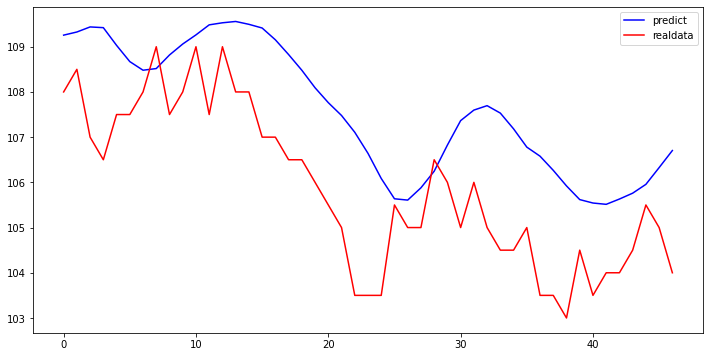

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

df = pd.read_csv("twstock2021.csv", encoding='big5')
dfprice = pd.DataFrame(df['收盤價'])
sequence_length = 10
scaler = MinMaxScaler()
dfprice = scaler.fit_transform(dfprice)
data = []
for i in range(len(dfprice) - sequence_length):
    data.append(dfprice[i: i + sequence_length + 1])
reshape_data = np.array(data)
x = reshape_data[:, :-1]
y = reshape_data[:, -1]
split_boundary = int(reshape_data.shape[0]*0.8)
train_x = x[: split_boundary]
test_x = x[split_boundary:]
train_y = y[: split_boundary]
test_y = y[split_boundary:]

model = load_model('stock_model.h5')
predict = model.predict(test_x)
predict = scaler.inverse_transform(predict)
test_y = scaler.inverse_transform(test_y)

plt.figure(figsize=(12,6))
plt.plot(predict, 'b-')
plt.plot(test_y, 'r-')
plt.legend(['predict', 'realdata'])
plt.show()